# Retail Strategy and Analytics - Task 2
## Store Trial Performance Evaluate
I will use R to complete this task.<br><br>
In this task, we need to evaluate the performance of a store trial which was performed in stores $77$, $86$ and $88$. We will use the $QVI\_data$ dataset to consider the monthly sales experience of each store.The monthly sales experience can be broken down by total sales revenue, total number of customers, and average number of transactions per customer.<br><br>
We need to create a measure to campare different control stores to each of the trial stores. To do this, we will need to write a measure function to help our comsuption.<br><br>
There are 6 parts for this task:<br>
1. Load Libraries & Datasets
2. Select Control Stores
3. Assessment of Trial
4. Trial Store 86
5. Trial Store 88
6. Conclusion

## Load Libraries & Datasets

In [1]:
install.packages('ggplot2')
install.packages('ggmosaic')
install.packages('rlang')

package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Windows\Temp\Rtmp6LXPjQ\downloaded_packages
package 'ggmosaic' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Windows\Temp\Rtmp6LXPjQ\downloaded_packages
package 'rlang' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Windows\Temp\Rtmp6LXPjQ\downloaded_packages


In [2]:
library(data.table)
library(ggplot2)
library(ggmosaic)
library(readr)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'ggmosaic' was built under R version 3.6.3"

In [3]:
data <- fread(paste0('QVI_data.csv'))

In [4]:
theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))

## Select Control Stores
We will select store 77, 86 and 88 as trial stores and control stores to be established stores that are operational for the entire observation period.<br><br>
We need to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of : montly overall sales revenue, monthly number of customers, and monthly number of transactions per customer.<br><br>
Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period.

In [5]:
data[, YEARMONTH := year(DATE)*100 + month(DATE)]

In [6]:
measureOverTime <- data[, .(totSales = sum(TOT_SALES), nCustomers = uniqueN(LYLTY_CARD_NBR), 
                            nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
                            nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
                            avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)), 
                        by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

In [7]:
storesWithFullObs <- unique(measureOverTime[, .N, STORE_NBR][N == 12, STORE_NBR])

preTrialMeasures <- measureOverTime[YEARMONTH < 201902 & STORE_NBR %in% storesWithFullObs, ]

In [8]:
calculateCorrelation <- function(inputTable, metricCol, storeComparison) 
{calcCorrTable = data.table(Store1 = numeric(), Store2 = numeric(), corr_measure = numeric())
    
storeNumbers <- unique(inputTable[, STORE_NBR])
    
for (i in storeNumbers) {calculatedMeasure = data.table("Store1" = storeComparison, "Store2" = i,
                                    "corr_measure" = cor(inputTable[STORE_NBR == storeComparison, 
                                    eval(metricCol)], inputTable[STORE_NBR == i, eval(metricCol)]))

                         calcCorrTable <- rbind(calcCorrTable, calculatedMeasure)}
    return(calcCorrTable)}

In [9]:
calculateMagnitudeDistance <- function(inputTable, metricCol, storeComparison) {
calcDistTable = data.table(Store1 = numeric(), Store2 = numeric(), YEARMONTH = numeric(), 
                           measure = numeric())
    
storeNumbers <- unique(inputTable[, STORE_NBR])
    
for (i in storeNumbers) {calculatedMeasure = data.table("Store1" = storeComparison, "Store2" = i, 
                                        "YEARMONTH" = inputTable[STORE_NBR == storeComparison, YEARMONTH],
                                        "measure" = abs(inputTable[STORE_NBR == storeComparison, 
                                        eval(metricCol)] - inputTable[STORE_NBR == i, eval(metricCol)]))
                         calcDistTable <- rbind(calcDistTable, calculatedMeasure)
}

minMaxDist <- calcDistTable[, .(minDist = min(measure), maxDist = max(measure)), 
                            by = c("Store1", "YEARMONTH")]
    
    distTable <- merge(calcDistTable, minMaxDist, by = c("Store1", "YEARMONTH"))
    
    distTable[, magnitudeMeasure := 1 - (measure - minDist)/(maxDist - minDist)]
    
    finalDistTable <- distTable[, .(mag_measure = mean(magnitudeMeasure)), by = .(Store1, Store2)]

    return(finalDistTable)
}

In [10]:
trial_store <- 77

corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)

corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

In [11]:
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)

magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [12]:
corr_weight <- 0.5

score_nSales <- merge(corr_nSales, magnitude_nSales, 
by = c("Store1","Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]

score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, 
by = c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]

In [13]:
score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))

score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

In [14]:
control_store <- score_Control[Store1 == trial_store,][order(-finalControlScore)][2, Store2]
control_store

[1] 233

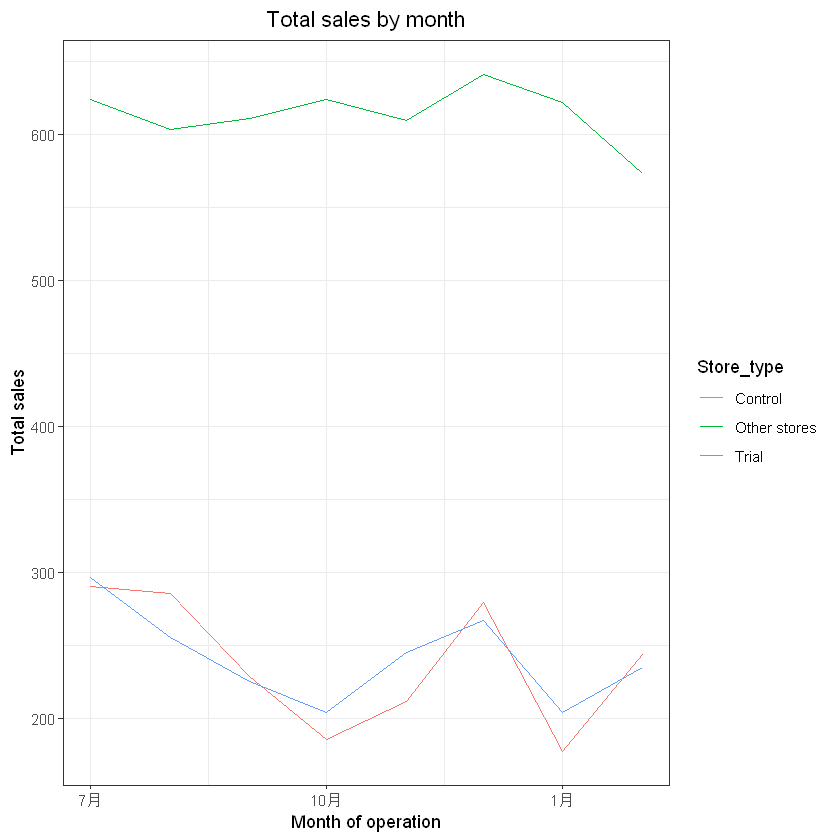

In [15]:
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                                                         ifelse(STORE_NBR == control_store,
                                                                "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) + geom_line() +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

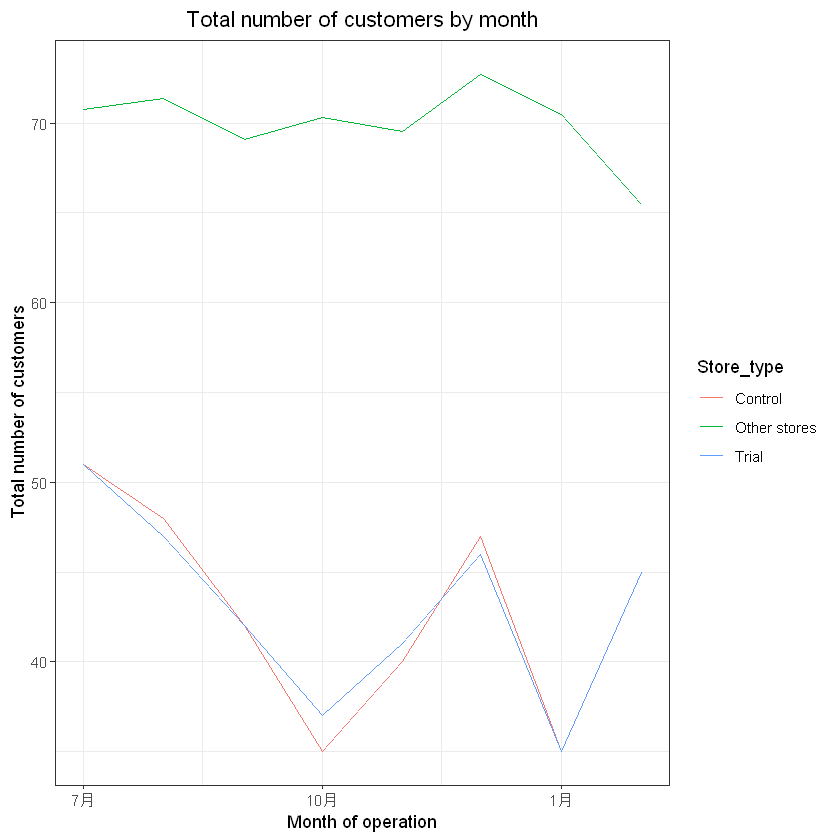

In [16]:
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) +geom_line() +
labs(x = "Month of operation", y = "Total number of customers", 
     title = "Total number of customers by month")

## Part 3. Assessment of Trial
The trial period goes from the start of March 2019 to June 2019. We now need to see if there has been an
uplift in overall chip sales.<br><br>
We will start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.<br><br>
We will also see the result in trial store 77 in this part.

In [17]:
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, 
                        sum(totSales)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, 
                                                                                 sum(totSales)]

In [18]:
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ ,
controlSales := totSales * scalingFactorForControlSales]

In [19]:
percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],
measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")], by = "YEARMONTH")[, percentageDiff :=
abs(controlSales-totSales)/controlSales]

In [20]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

degreesOfFreedom <- 7

percentageDiff[, tValue := (percentageDiff - 0)/stdDev][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100,
YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201905 & YEARMONTH > 201901, .(TransactionMonth, tValue)]

TransactionMonth,tValue
2019-02-01,1.183534
2019-03-01,7.339116
2019-04-01,12.476373


In [21]:
qt(0.95, df = degreesOfFreedom)

[1] 1.894579

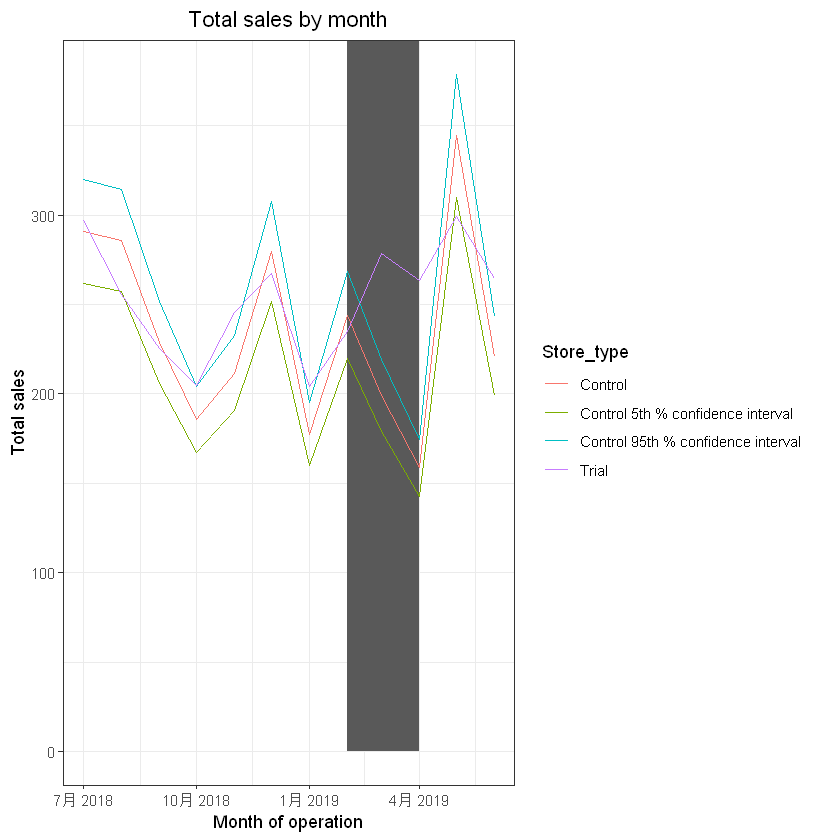

In [22]:
measureOverTimeSales <- measureOverTime

pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/%100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][Store_type %in% c("Trial", "Control"), ]

pastSales_Controls95 <- pastSales[Store_type == "Control",][, totSales := totSales * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

pastSales_Controls5 <- pastSales[Store_type == "Control",][, totSales := totSales * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]

trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [23]:
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(nCustomers)]

In [24]:
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",ifelse(STORE_NBR == control_store,
"Control", "Other stores"))
]

In [25]:
percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH",
 "controlCustomers")],

measureOverTimeCusts[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],
by = "YEARMONTH")[, percentageDiff := abs(controlCustomers - nCustomers)/controlCustomers]

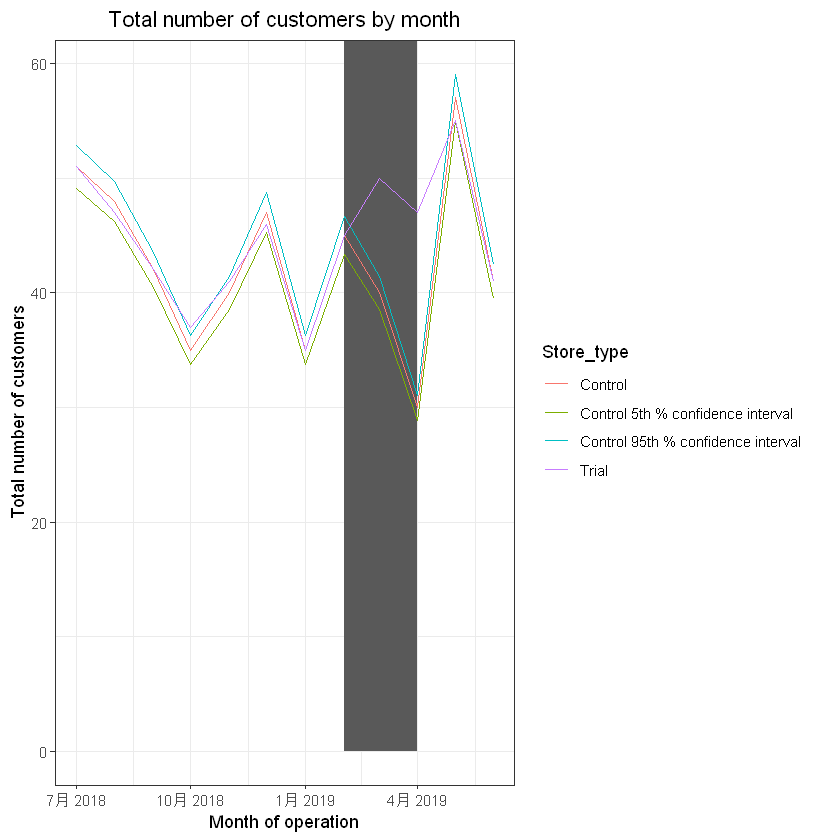

In [26]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <- 7

pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][Store_type %in% c("Trial", "Control"), ]

pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",][, nCusts := nCusts * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 - stdDev * 2)][, Store_type := "Control 5th % confidence interval"]
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() +
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

## Part 4. Trial Store 86

In [27]:
measureOverTime <- data[, .(totSales = sum(TOT_SALES), nCustomers = uniqueN(LYLTY_CARD_NBR),
nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)
), by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

trial_store <- 86
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)

magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1",
"Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]

score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by =
c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1- corr_weight)]

score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]


control_store <- score_Control[Store1 == trial_store,][order(-finalControlScore)][2, Store2]
control_store

[1] 155

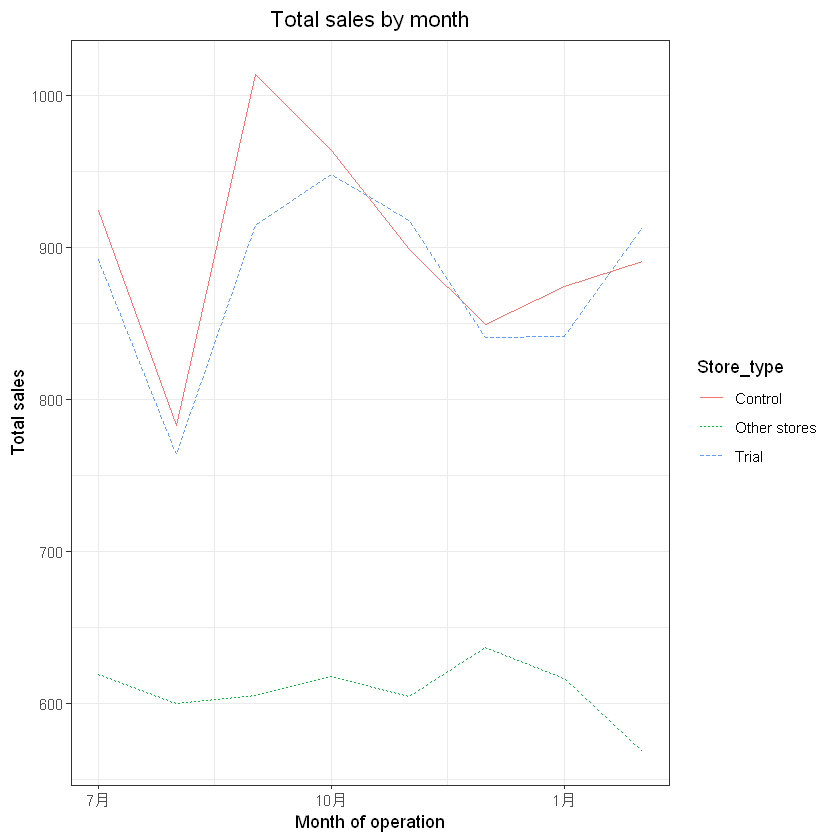

In [28]:
measureOverTimeSales <- measureOverTime

pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]

ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
geom_line(aes(linetype = Store_type)) + labs(x = "Month of operation", y = "Total sales", 
                                             title = "Total sales by month")

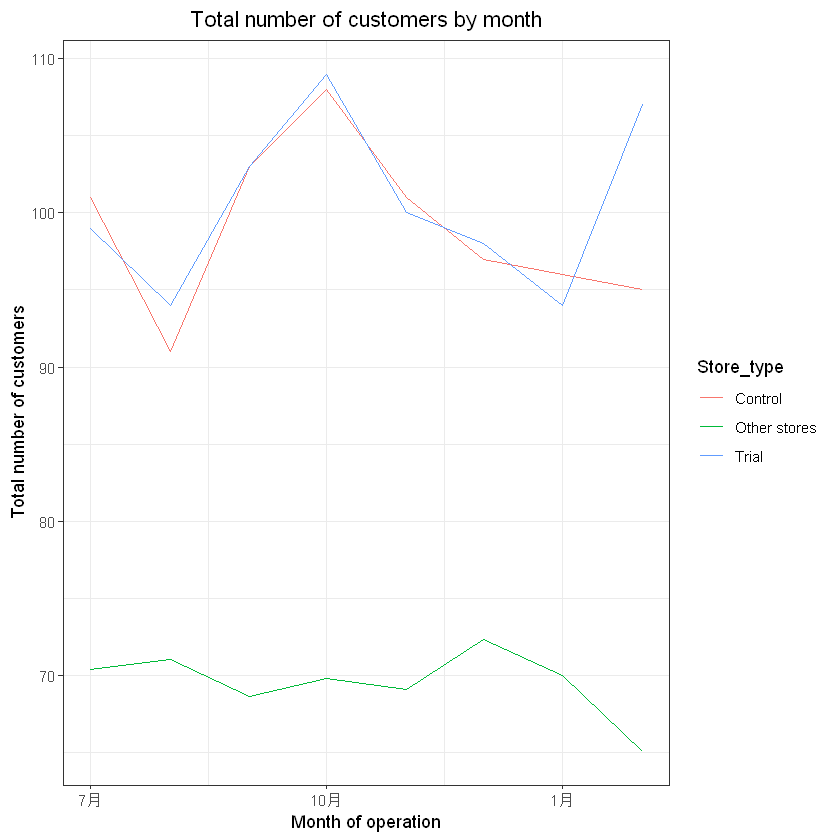

In [29]:
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]

ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) + geom_line() +
labs(x = "Month of operation", y = "Total number of customers",
     title = "Total number of customers by month")

In [30]:
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, 
                                                    sum(totSales)]


measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ ,
controlSales := totSales * scalingFactorForControlSales]

percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],
measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],by = "YEARMONTH")[, percentageDiff :=
abs(controlSales-totSales)/controlSales]

In [31]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff]) 

degreesOfFreedom <- 7

measureOverTimeSales <- measureOverTime

pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][Store_type %in% c("Trial", "Control"), ]

pastSales_Controls95 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 + stdDev * 2)][, Store_type := "Control 95th % confidence interval"]

pastSales_Controls5 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 - stdDev * 2)][, Store_type := "Control 5th % confidence interval"]

trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

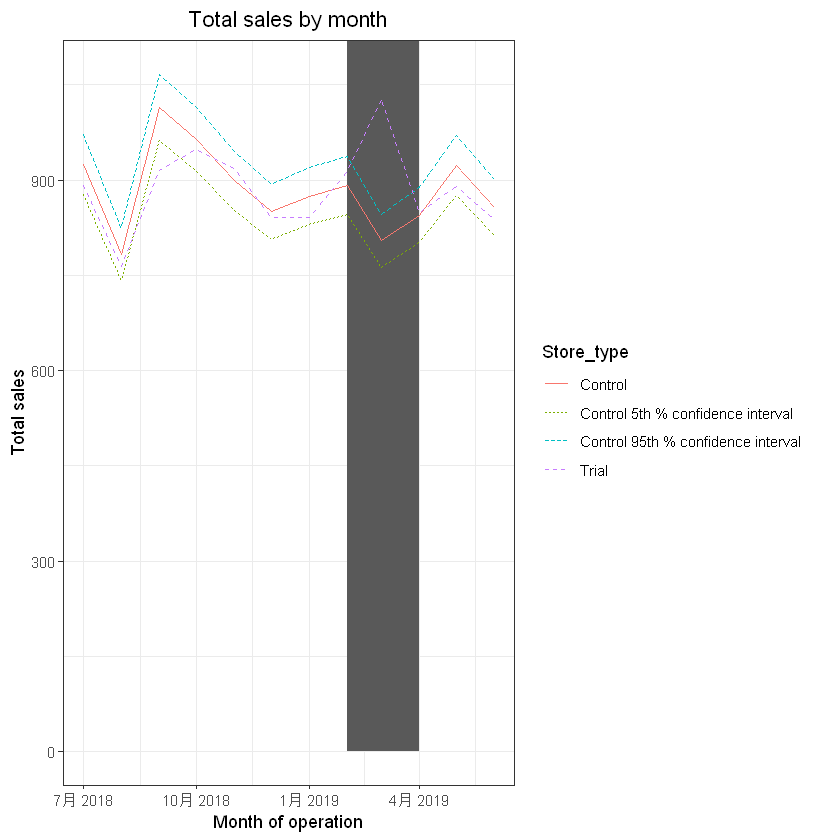

In [32]:
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

In [33]:
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(nCustomers)]

measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",ifelse(STORE_NBR == control_store,
"Control", "Other stores"))]

percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],
measureOverTime[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],by = "YEARMONTH"
)[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

In [34]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

degreesOfFreedom <- 7

pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][Store_type %in% c("Trial", "Control"), ]

pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 + stdDev * 2)][, Store_type := "Control 95th % confidence interval"]

pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 - stdDev * 2)][, Store_type := "Control 5th % confidence interval"]

trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

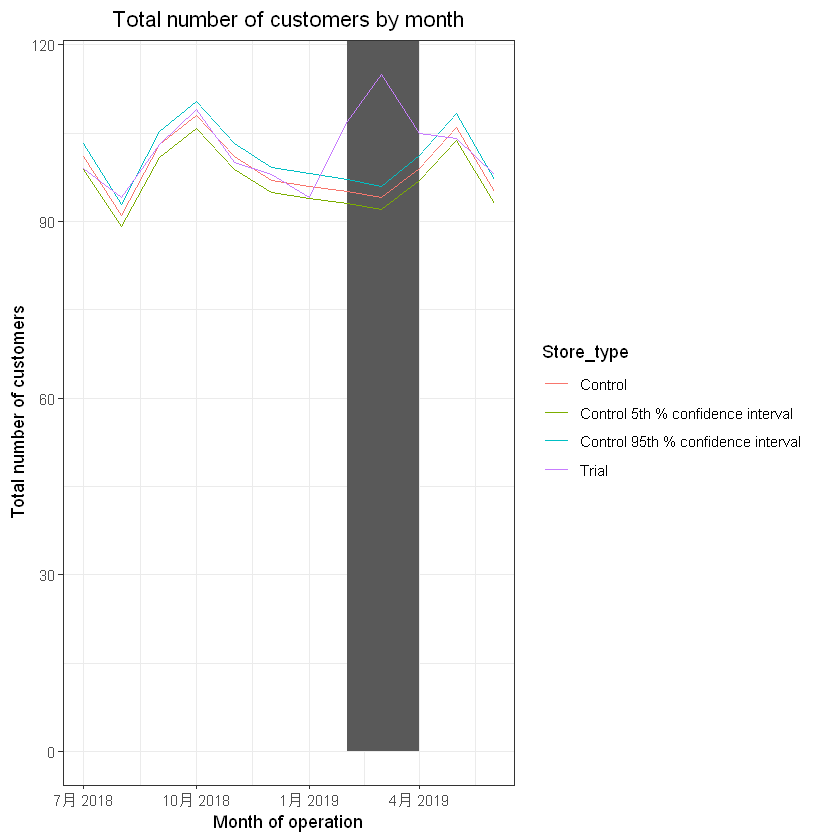

In [35]:
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() +
labs(x = "Month of operation", y = "Total number of customers", 
     title = "Total number of customers by month")

## Part 5. Trial Store 88

In [36]:
measureOverTime <- data[, .(totSales = sum(TOT_SALES),nCustomers = uniqueN(LYLTY_CARD_NBR),
nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)), by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR,YEARMONTH)]

In [37]:
trial_store <- 88

corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)

corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

In [38]:
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)

magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1",
"Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1-corr_weight)]

score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by =
c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1- corr_weight)]

score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))

score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

control_store <- score_Control[Store1 == trial_store,][order(-finalControlScore)][2, Store2]

control_store

[1] 237

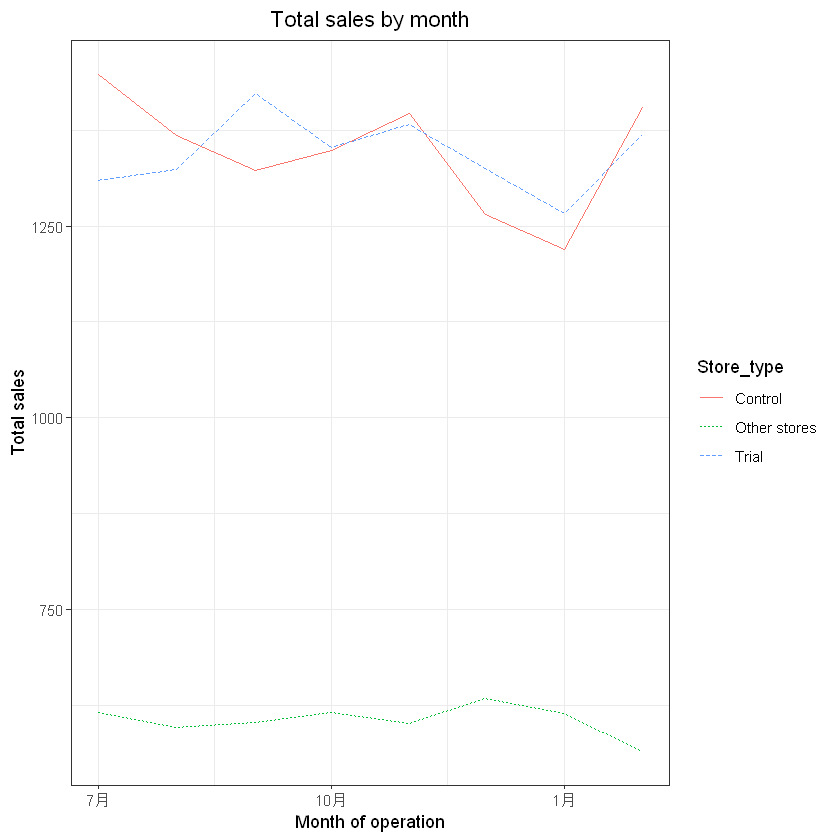

In [39]:
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) + geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

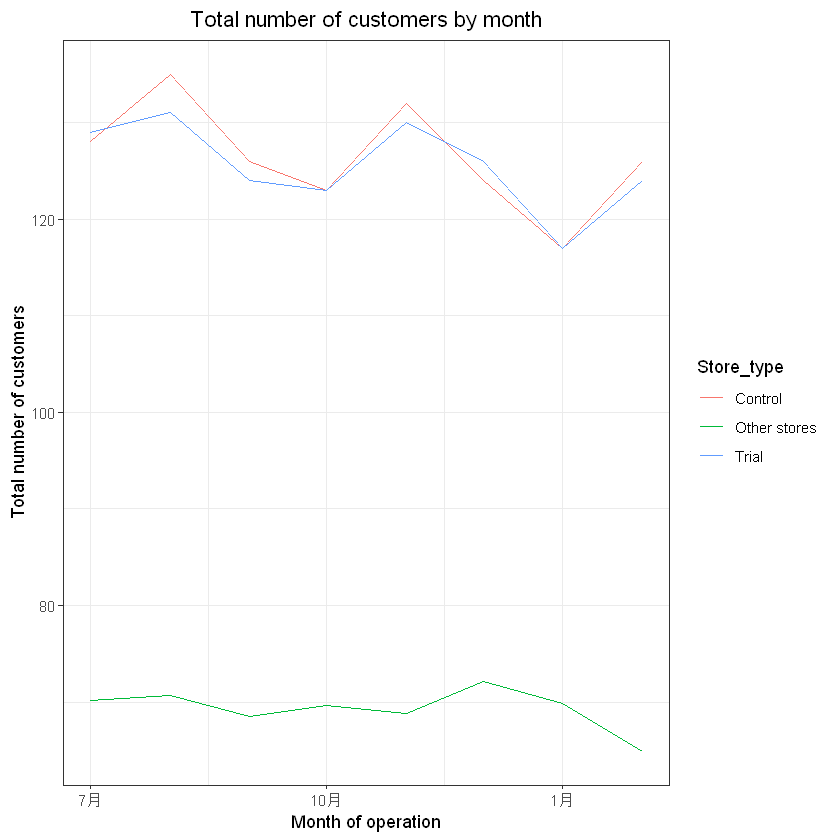

In [40]:
measureOverTimeCusts <- measureOverTime

pastCustomers <- measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][YEARMONTH < 201903 , ]

ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) + geom_line() +
labs(x = "Month of operation", y = "Total number of customers", 
     title = "Total number of customers by month")

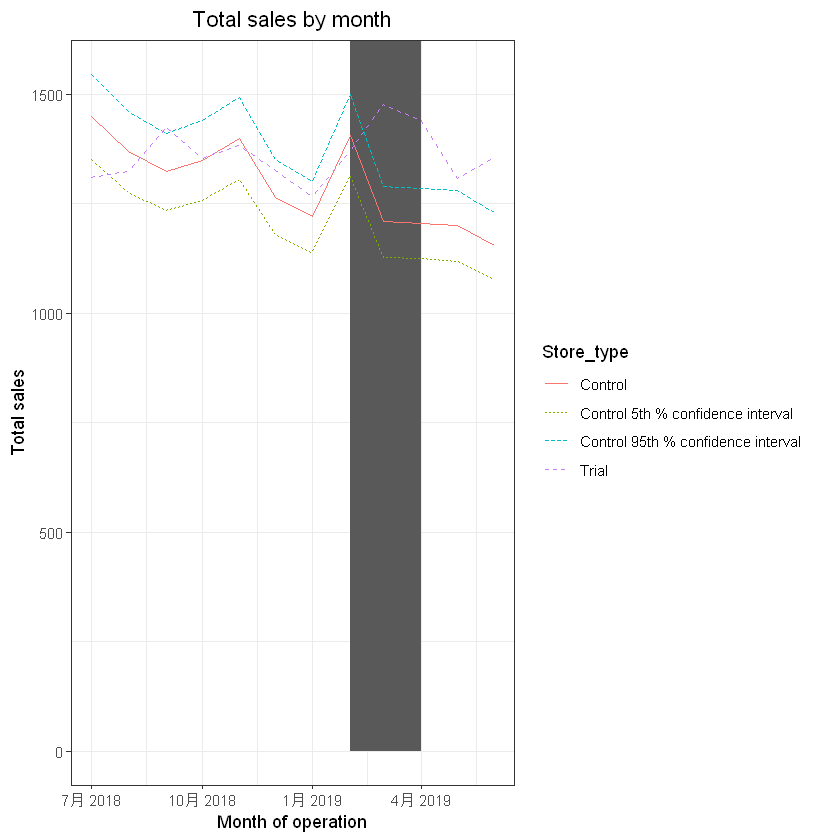

In [41]:
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(totSales)]

measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ ,
controlSales := totSales * scalingFactorForControlSales]

percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],
measureOverTime[STORE_NBR == trial_store, c("totSales","YEARMONTH")],by = "YEARMONTH"
)[, percentageDiff := abs(controlSales-totSales)/controlSales]

stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

degreesOfFreedom <- 7

measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")
][Store_type %in% c("Trial", "Control"), ]

pastSales_Controls95 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 + stdDev * 2)][, Store_type := "Control 95th % confidence interval"]

pastSales_Controls5 <- pastSales[Store_type == "Control",][, totSales := totSales * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]

trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

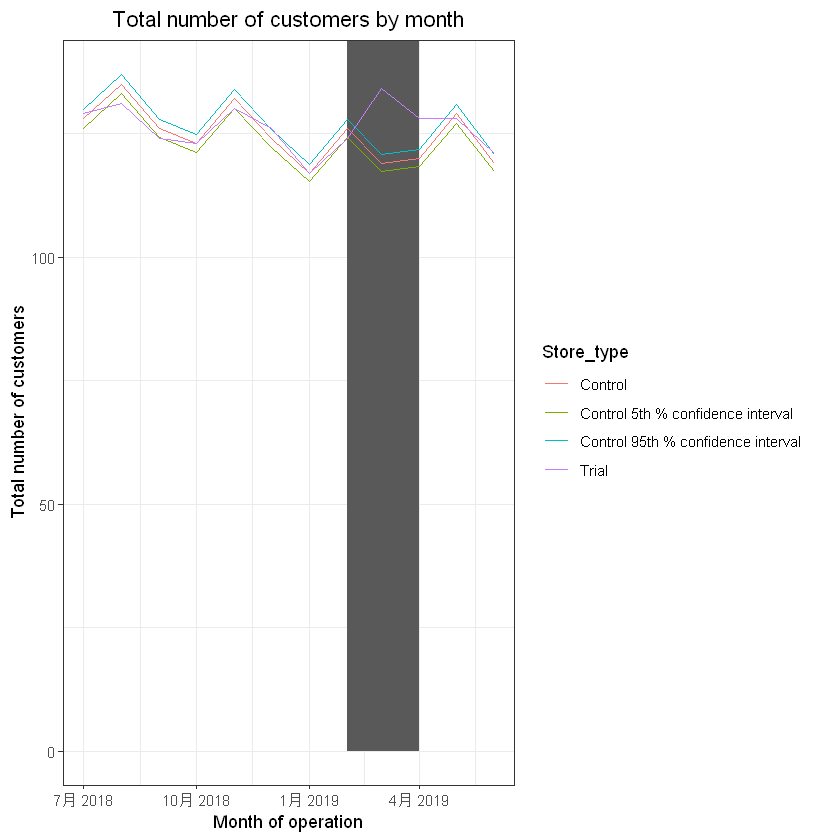

In [42]:
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(nCustomers)]

measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",ifelse(STORE_NBR == control_store,
                                                                  "Control", "Other stores"))]

percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],
measureOverTime[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],by = "YEARMONTH"
)[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

degreesOfFreedom <- 7 

pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][Store_type %in% c("Trial", "Control"), ]

pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",][, nCusts := nCusts * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 - stdDev * 2)][, Store_type := "Control 5th % confidence interval"]

trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() +
labs(x = "Month of operation", y = "Total number of customers", 
     title = "Total number of customers by month")


## Part 6. Conclusion

We have found control stores 233, 155, 237 for trial stores 77, 86, 88 repectively.<br><br>
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of three trial months but this is not the case for trial store 86. Overall, the trial shows a significant increase in sales.